In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readxl)
library(janitor)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (24): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (14): ...1, Prize Money, Turned Pro, Seasons, Titles, Best Season, Retir...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,rank,prize_money,height_cm,seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
25.96794,249.0283,3416440,185.7913,6.494652


25%   50%   75% 
125.5 249.0 372.5

age,rank,prize_money,height_cm,seasons,category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
33,1,119601561,185.0000,19,category_1
32,2,139144944,188.0000,17,category_1
38,3,129231891,185.0000,22,category_1
23,4,10507693,185.7913,5,category_1
26,5,22132368,185.0000,10,category_1
21,6,10425605,185.7913,4,category_1
22,7,20028563,198.0000,8,category_1
23,8,3580862,185.7913,3,category_1
31,9,12067808,183.0000,11,category_1


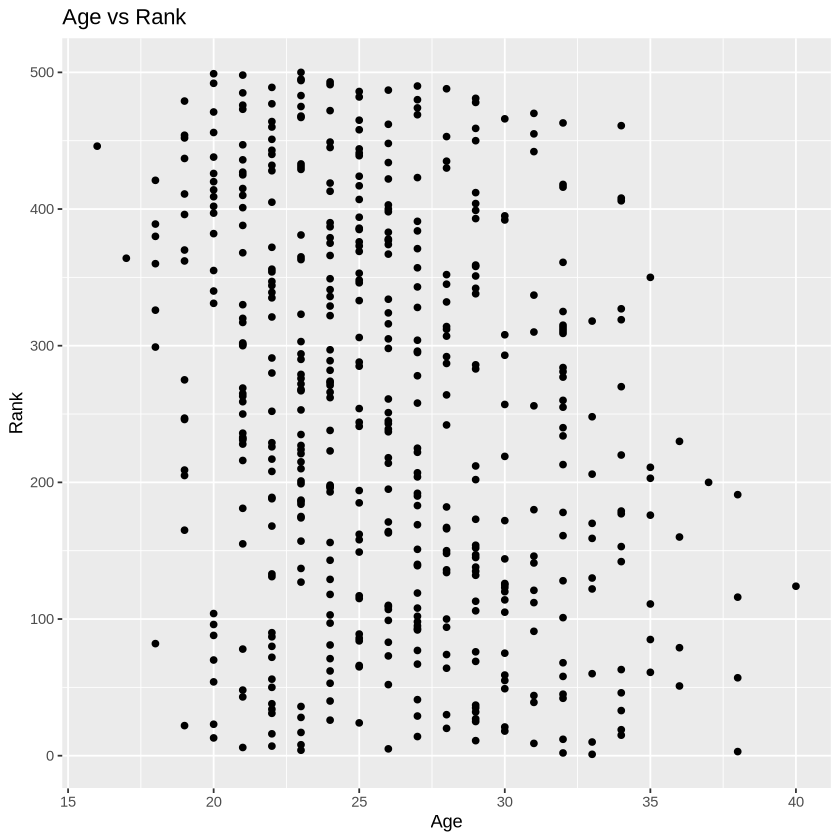

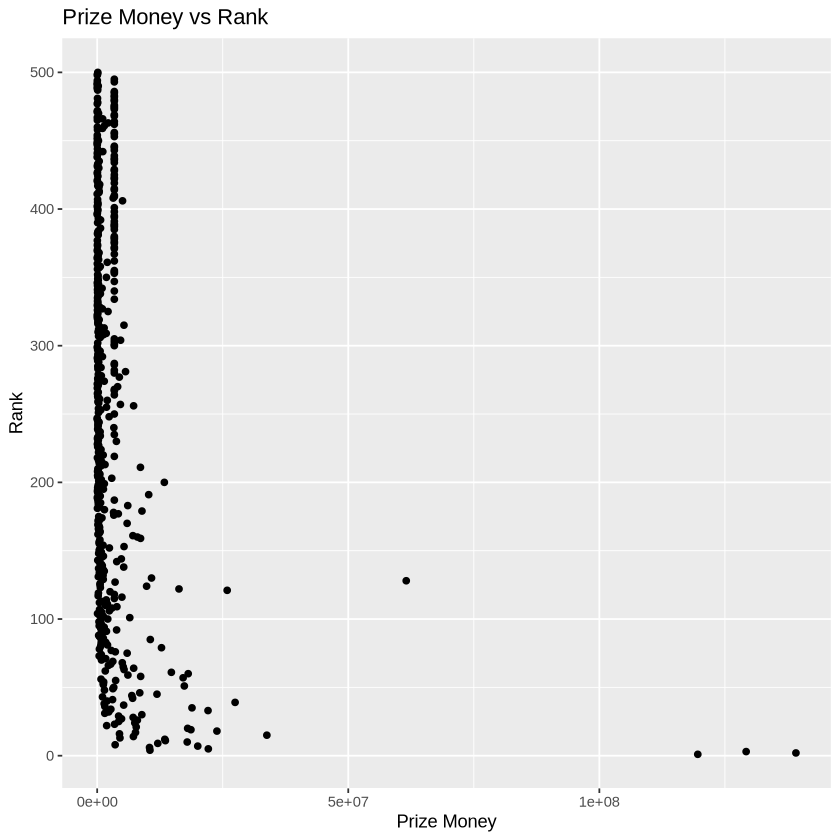

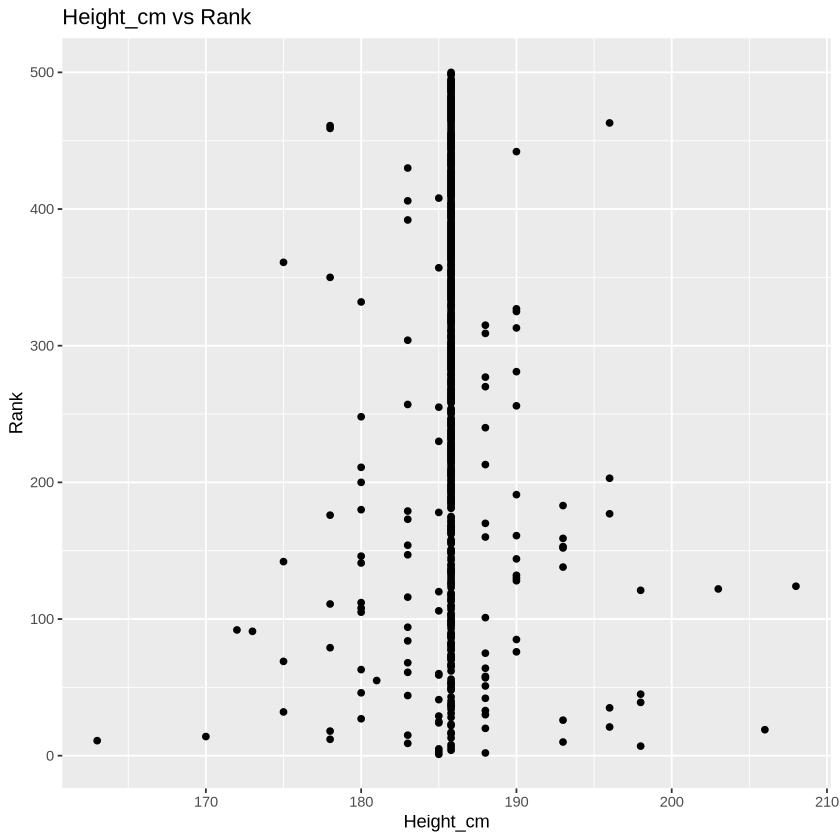

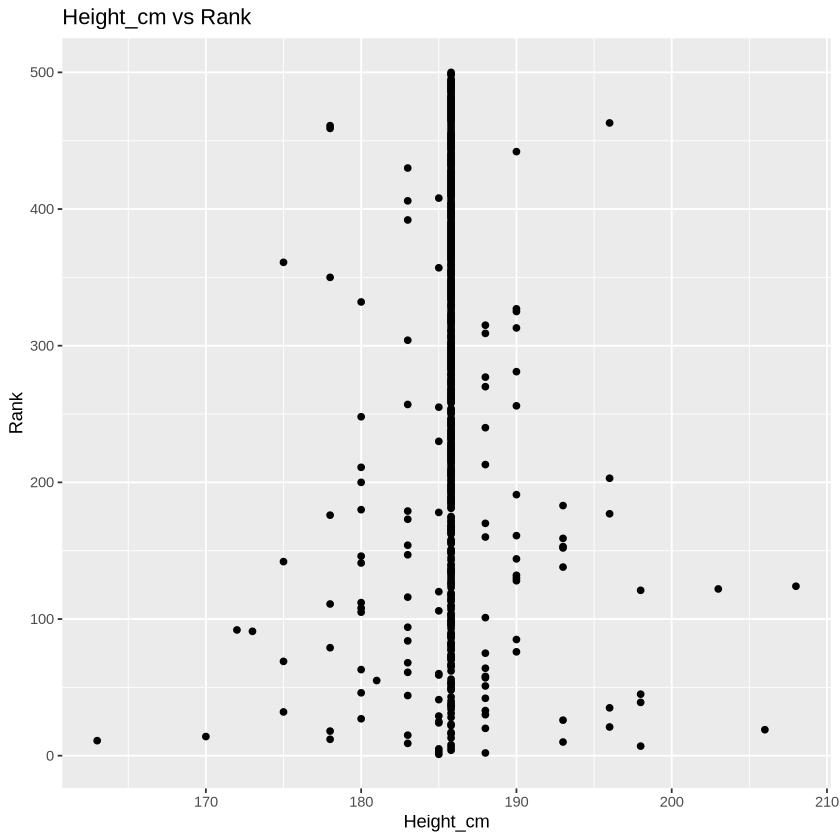

In [10]:
tennis_data <- read_csv("Data/player_stats.csv", skip = 1)

tennis_df <- tennis_data |>
    clean_names() |>
    select(age, current_rank, prize_money, height, seasons) |>
    separate(col = height, 
            into = c("height_cm", "discard"), 
           sep = " ") |>
    separate(col = current_rank, 
            into = c("rank", "discard_1"), 
           sep = " ") |>
    separate(col = age, 
            into = c("age", "discard_2"), 
           sep = " ") |>
    select(-discard_2, -discard_1, -discard) |>
    mutate(age = as.numeric(age),
           rank = as.numeric(rank),
           height_cm = as.numeric(height_cm)) |>
           arrange(desc(rank))

means <- tennis_df |>
            select(age:seasons) |>
            map_dfr(mean, na.rm = TRUE)
means

tennis_df <- tennis_df |>
                replace_na(list(age = 25.96794, 
                                prize_money = 3416440, 
                                height_cm = 185.7913, 
                                seasons = 6.494652)) |>
    arrange(rank)
    


rank_quantile <- tennis_df |>
    select(rank) |>
    quantile(probs = c(0.25, 0.5, 0.75), na.rm = TRUE)
rank_quantile

category_columns <- tennis_df |>
    mutate(category_1 = rank < 125.5) |>
    mutate(category_2 = 125.5 < rank & rank < 249) |>
    mutate(category_3 = 249 < rank & rank < 372.5) |>
    mutate(category_4 = 372.5 < rank) 


tennis_df_longer <- category_columns |> 
    pivot_longer(cols = category_1:category_4, 
                 names_to = "category", 
                 values_to = "status") |>
    filter(status == "TRUE") |>
    select(-status) |>
    drop_na()
tennis_df_longer
    
tennis_split <- initial_split(tennis_df_longer, prop = 0.75, strata = category)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

tennis_viz_age <- ggplot(tennis_df_longer, (aes(x = age, y = rank))) +
                  geom_point() +
                  labs(x = "Age", y = "Rank", title = "Age vs Rank")
tennis_viz_age

tennis_viz_prize_money <- ggplot(tennis_df_longer, (aes(x = prize_money, y = rank))) +
                  geom_point() +
                  labs(x = "Prize Money", y = "Rank", title = "Prize Money vs Rank")
tennis_viz_prize_money

tennis_viz_height_cm <- ggplot(tennis_df_longer, (aes(x = height_cm, y = rank))) +
                  geom_point() +
                  labs(x = "Height_cm", y = "Rank", title = "Height_cm vs Rank")
tennis_viz_height_cm

tennis_viz_seasons <- ggplot(tennis_df_longer, (aes(x = seasons, y = rank))) +
                  geom_point() +
                  labs(x = "Seasons", y = "Rank", title = "Seasons vs Rank")
tennis_viz_height_cm